In [1]:
%whos
#%reset

Interactive namespace is empty.


In [2]:
#importing all the packages that I might need
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="white")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 300)
from scipy.stats import norm

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# from sklearn import preprocessing

In [3]:
data_grad = pd.read_excel('Data/graduation_rates_public_school.xlsx',sheet_name='All',header=8)
data_ell = pd.read_excel('Data/graduation_rates_public_school.xlsx',sheet_name='ELL',header=8)
data_swd = pd.read_excel('Data/graduation_rates_public_school.xlsx',sheet_name='SWD',header=8)
data_ethnicity = pd.read_excel('Data/graduation_rates_public_school.xlsx',sheet_name='Ethnicity',header=8)
data_gender = pd.read_excel('Data/graduation_rates_public_school.xlsx',sheet_name='Gender',header=8)
data_poverty = pd.read_excel('Data/graduation_rates_public_school.xlsx',sheet_name='Poverty',header=8)

In [4]:
df_created = [data_ell,data_swd,data_ethnicity,data_gender,data_poverty]

In [5]:
data_grad_2014 = data_grad[data_grad['Cohort Year'] == 2014]
data_grad_2014 = data_grad_2014[data_grad_2014['Cohort'] == '4 year August']

In [6]:
data_grad_2014 = data_grad_2014[['DBN','School Name','#','% of cohort']].reset_index()

In [7]:
data_grad_2014 = data_grad_2014[['DBN','School Name','#','% of cohort']]
data_grad_2014.head()

,DBN,School Name,#,% of cohort
0,01M292,Orchard Collegiate Academy,29,0.965517
1,01M448,University Neighborhood High School,88,0.931818
2,01M450,East Side Community School,92,0.967391
3,01M458,Forsyth Satellite Academy,73,0.369863
4,01M509,Marta Valle High School,42,0.642857


In [8]:
data_grad_2014.sample(10)

,DBN,School Name,#,% of cohort
182,09X564,Claremont International HS,88,0.659091
116,06M467,High School for Law and Public Service,154,0.668831
473,32K545,EBC High School for Public Service - Bushwick,130,0.869231
395,25Q281,East-West School of International Studies,85,0.941176
419,27Q351,Rockaway Collegiate High School,93,0.666667
424,28Q167,Metropolitan Expeditionary Learning School,110,0.972727
32,02M408,Professional Performing Arts High School,124,0.935484
194,10X353,World View High School,92,0.804348
352,21K344,Rachel Carson High School for Coastal Studies,158,0.784810
312,17K590,Medgar Evers College Preparatory School,207,0.975845


In [9]:
#Create a function to clean the dataframes from the different excel sheets

def my_cleaner(dataframe):
#select year 2014 and cohort 4 year August
    dataframe = dataframe[dataframe['Cohort Year'] == 2014]
    dataframe = dataframe[dataframe['Cohort'] == '4 year August']
#keep only 3 columns from the dataframes  
    cols = [col for col in dataframe.columns if col in ['DBN','Category','#']]
    dataframe = dataframe[cols]
#transform the categories into columns
    dataframe = dataframe.groupby(['DBN','Category'])['#'].aggregate('first').unstack()
#due to columns removal - reset the index
    dataframe = dataframe.reset_index()
    return dataframe

In [10]:
dataframes_to_merge=[my_cleaner(df) for df in df_created]
len(dataframes_to_merge)

In [11]:
dataset = data_grad_2014
for x in range(5):
    dataset = dataset.merge(dataframes_to_merge[x],on = 'DBN',how = 'inner')

In [12]:
dataset = dataset.rename(columns={'#':'total_stud','% of cohort':'grad_rate'})

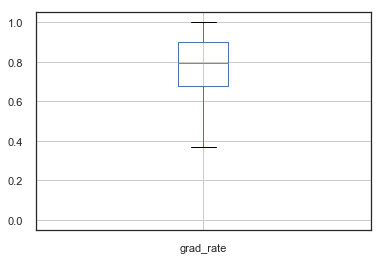

In [13]:
dataset.boxplot(['grad_rate'])

In [19]:
dataset.isna().sum()

DBN                  0
School Name          0
total_stud           0
grad_rate            4
ELL                 91
Former ELL          60
Not ELL              0
Not SWD              1
SWD                 10
Asian               78
Black                8
Hispanic             4
Multi-Racial       237
Native American    249
White               74
Female               3
Male                11
Econ Disadv          0
Not Econ Disadv      5
dtype: int64

In [20]:
dataset[dataset['grad_rate'].isnull()]

,DBN,School Name,total_stud,grad_rate,ELL,Former ELL,Not ELL,Not SWD,SWD,Asian,Black,Hispanic,Multi-Racial,Native American,White,Female,Male,Econ Disadv,Not Econ Disadv
264,14K322,FOUNDATIONS ACADEMY,1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
291,16K393,FREDERICK DOUGLASS ACADEMY IV SECONDARY SCHOOL,1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
323,18K589,ARTS & MEDIA PREPARATORY ACADEMY,4,NaN,NaN,NaN,4.0,4.0,NaN,NaN,3.0,1.0,NaN,NaN,NaN,2.0,2.0,4.0,NaN
333,19K422,Spring Creek Community School,1,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [21]:
#remove missing or incorrect value in grad_rate to keep only numeric
dataset=dataset[pd.to_numeric(dataset.grad_rate, errors='coerce').notnull()]

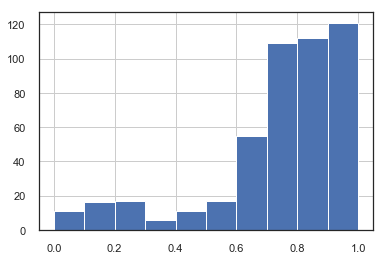

In [22]:
dataset.grad_rate.hist()

In [23]:
columns_tobe_changed = list(dataset.columns)[4:]
columns_tobe_changed

['ELL',
 'Former ELL',
 'Not ELL',
 'Not SWD',
 'SWD',
 'Asian',
 'Black',
 'Hispanic',
 'Multi-Racial',
 'Native American',
 'White',
 'Female',
 'Male',
 'Econ Disadv',
 'Not Econ Disadv']

In [24]:
new_cols = ['prob_'+x for x in columns_tobe_changed]
new_cols

['prob_ELL',
 'prob_Former ELL',
 'prob_Not ELL',
 'prob_Not SWD',
 'prob_SWD',
 'prob_Asian',
 'prob_Black',
 'prob_Hispanic',
 'prob_Multi-Racial',
 'prob_Native American',
 'prob_White',
 'prob_Female',
 'prob_Male',
 'prob_Econ Disadv',
 'prob_Not Econ Disadv']

In [29]:
# for each demographic category, create new columns with each attribute's % of total students
dataset[new_cols] = round(dataset[columns_tobe_changed].div(dataset.total_stud, axis=0),2)
# dataset.head()

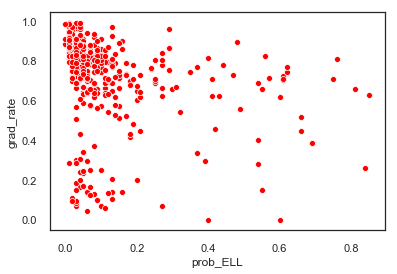

In [30]:
sns.scatterplot(dataset['prob_ELL'], dataset.grad_rate, color = 'red')

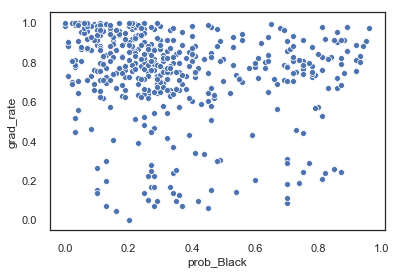

In [31]:
sns.scatterplot(dataset['prob_Black'], dataset.grad_rate)

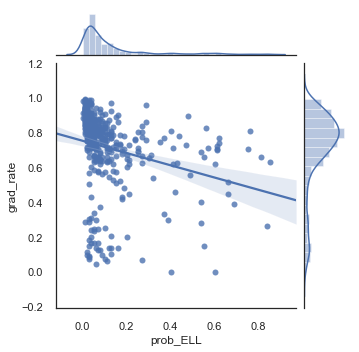

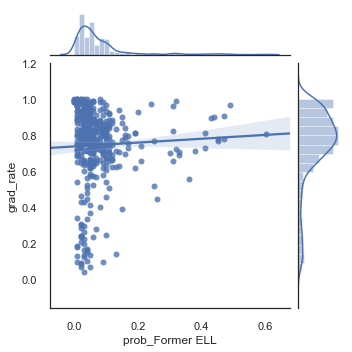

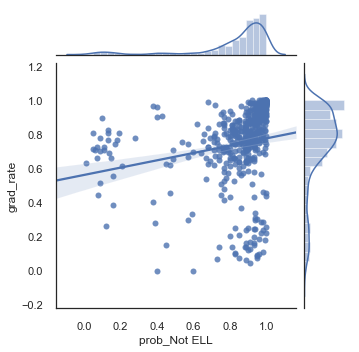

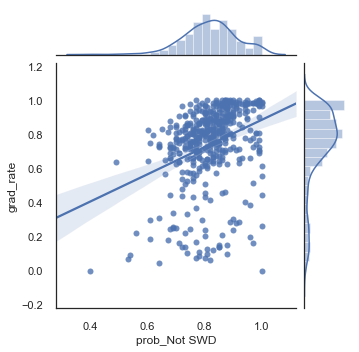

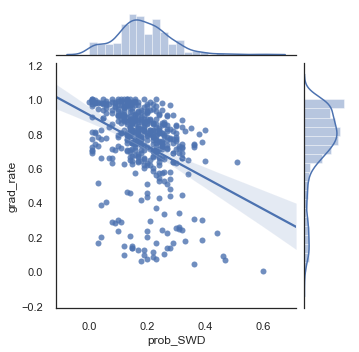

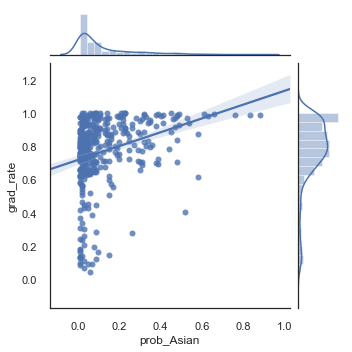

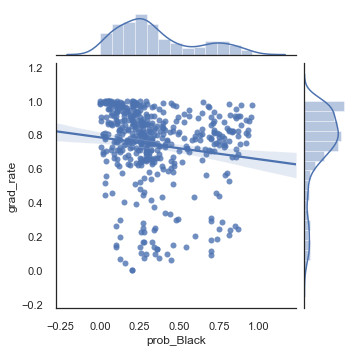

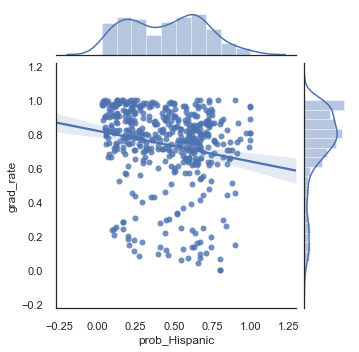

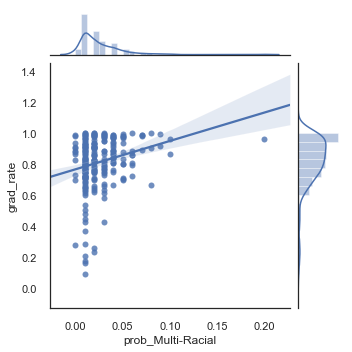

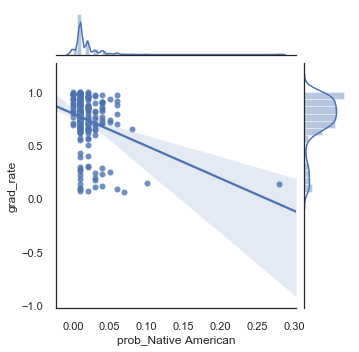

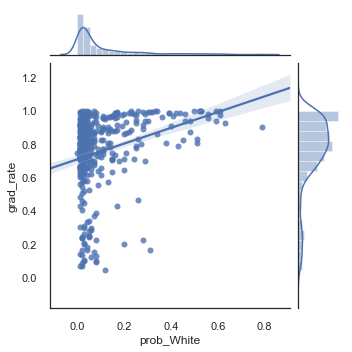

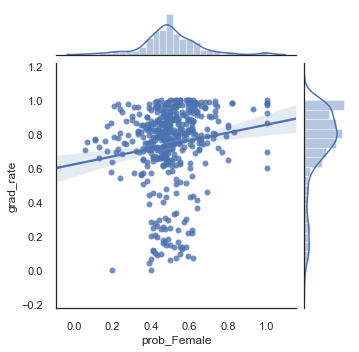

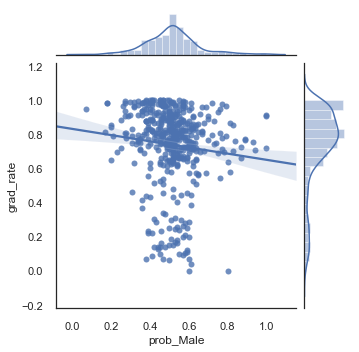

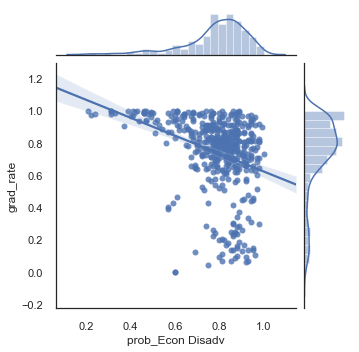

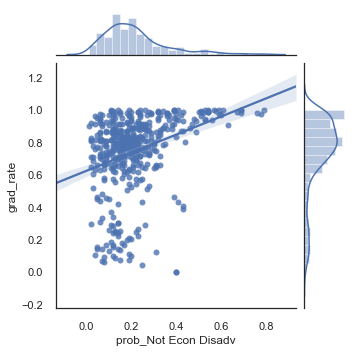

In [32]:
for col in new_cols:
    sns.jointplot(x=col, y='grad_rate', data=dataset, kind="reg",height=5)

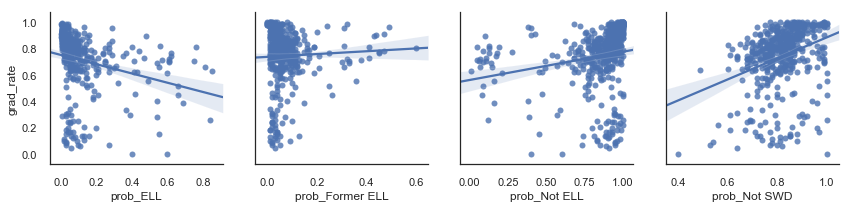

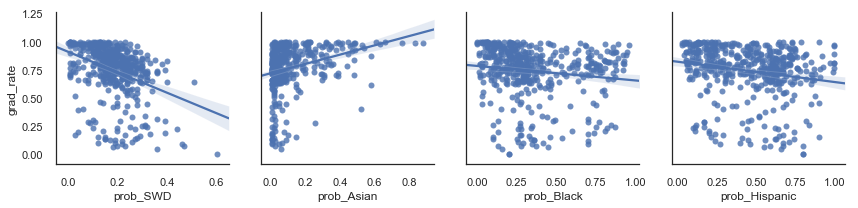

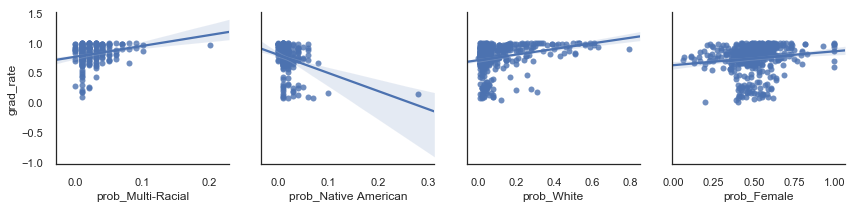

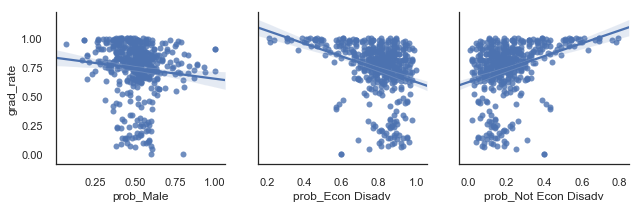

In [33]:
n = 4
row_groups= [new_cols[i:i+n] for i in range(0, len(new_cols), n) ]
for i in row_groups:
    pp = sns.pairplot(data=dataset, y_vars=['grad_rate'],x_vars=i, kind="reg", height=3)

In [67]:
dataset.to_csv("dataset.csv")

In [34]:
# two rows have grad rate of 0%.  Removing them
dataset[dataset['grad_rate'] == 0]

,DBN,School Name,total_stud,grad_rate,ELL,Former ELL,Not ELL,Not SWD,SWD,Asian,Black,Hispanic,Multi-Racial,Native American,White,Female,Male,Econ Disadv,Not Econ Disadv,prob_ELL,prob_Former ELL,prob_Not ELL,prob_Not SWD,prob_SWD,prob_Asian,prob_Black,prob_Hispanic,prob_Multi-Racial,prob_Native American,prob_White,prob_Female,prob_Male,prob_Econ Disadv,prob_Not Econ Disadv
130,07X520,FOREIGN LANGUAGE ACADEMY OF GLOBAL STUDIES,5,0.0,3.0,NaN,2.0,5.0,NaN,NaN,1.0,4.0,NaN,NaN,NaN,1.0,4.0,3.0,2.0,0.6,NaN,0.4,1.0,NaN,NaN,0.2,0.8,NaN,NaN,NaN,0.2,0.8,0.6,0.4
167,09X276,LEADERSHIP INSTITUTE,5,0.0,2.0,NaN,3.0,2.0,3.0,NaN,1.0,4.0,NaN,NaN,NaN,2.0,3.0,3.0,2.0,0.4,NaN,0.6,0.4,0.6,NaN,0.2,0.8,NaN,NaN,NaN,0.4,0.6,0.6,0.4


In [35]:
d = dataset[dataset['grad_rate'] > 0]
len(dataset)-len(d)

2

In [36]:
filtered_cols_d = [
'total_stud',
       'prob_ELL', 'prob_Former ELL','prob_SWD', 'prob_Asian', 'prob_Black',
       'prob_Hispanic', 'prob_White', 'prob_Female', 'prob_Econ Disadv'
]

In [37]:
#Replace missing value with 0
d = d.fillna(0)

features_model = sm.OLS(endog=d['grad_rate'], exog=sm.add_constant(d[filtered_cols_d]) ).fit()
features_model.summary()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     20.44
Date:                Sun, 01 Sep 2019   Prob (F-statistic):           2.00e-31
Time:                        20:21:48   Log-Likelihood:                 121.49
No. Observations:                 473   AIC:                            -221.0
Df Residuals:                     462   BIC:                            -175.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7158      0.330      2.171      0.030       0.068       1.364
total_stud       -1.665e-05    5.7e-05     -0.292      0.770      -0.000    9.54e-05
prob_ELL            -0.6578      0.078     -8.413      0.000      -0.811      -0.504
prob_Former ELL      0.6073      0.140      4.334      0.000       0.332       0.883
prob_SWD            -0.6240      0.129     -4.842      0.000      -0.877      -0.371
prob_Asian           0.5924      0.359      1.649      0.100      -0.114       1.299
prob_Black           0.4063      0.341      1.191      0.234      -0.264       1.077
prob_Hispanic        0.4932      0.341      1.446      0.149      -0.177       1.163
prob_White           0.4099      0.343      1.194      0.233      -0.265       1.085
prob_Female          0.0333      0.062      0.534      0.594      -0.089       0.156
prob_Econ Disadv    -0.3886      0.104     -3.730      0.000      -0.593      -0.184
==============================================================================
Omnibus:                      150.443   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              362.330
Skew:                          -1.630   Prob(JB):                     2.09e-79
Kurtosis:                       5.786   Cond. No.                     2.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
# for col in filtered_cols:
#     sns.jointplot(x=col, y='grad_log', data=dataset, kind="reg",height=5)

In [38]:
def checkresiduals(df, target, sm_model):
    # checking for our model - Homoscedasticity,  Independence of residuals
    pred_val = sm_model.fittedvalues.copy()
    true_val = df[target].values.copy()
    residual = true_val - pred_val

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#     fig, ax = plt.subplots(figsize=(8, 6))
    ax1.hist(residual, density=True, bins=30)
    ax2.scatter(df[target],residual)
    ax2.set_title('Residual Scatterplot')
    plt.show()

In [60]:
d.iloc[:,:11].sample(10)

,DBN,School Name,total_stud,grad_rate,ELL,Former ELL,Not ELL,Not SWD,SWD,Asian,Black
48,02M449,Vanguard High School,122,0.795082,6.0,5.0,111.0,98.0,24.0,4.0,41.0
278,15K429,Digital Arts and Cinema Technology High School,26,0.961538,1.0,0.0,25.0,20.0,6.0,0.0,18.0
57,02M531,Repertory Company High School for Theatre Arts,65,0.984615,0.0,6.0,59.0,54.0,11.0,2.0,26.0
144,08X320,Pelham Lab High School,108,0.657407,10.0,8.0,90.0,88.0,20.0,10.0,21.0
281,15K463,Secondary School for Journalism,60,0.633333,7.0,6.0,47.0,50.0,10.0,3.0,28.0
459,30Q580,Baccalaureate School for Global Education,76,0.986842,0.0,0.0,76.0,74.0,2.0,31.0,0.0
474,32K549,The Brooklyn School for Social Justice,105,0.742857,37.0,8.0,60.0,88.0,17.0,1.0,19.0
18,02M300,Urban Assembly School of Design and Constructi...,86,0.720930,3.0,7.0,76.0,69.0,17.0,1.0,20.0
380,24Q299,Bard High School Early College Queens,151,0.993377,0.0,0.0,151.0,149.0,2.0,49.0,20.0
262,13K674,"City Polytechnic High School of Engineering, A...",110,0.763636,0.0,3.0,107.0,90.0,20.0,5.0,82.0


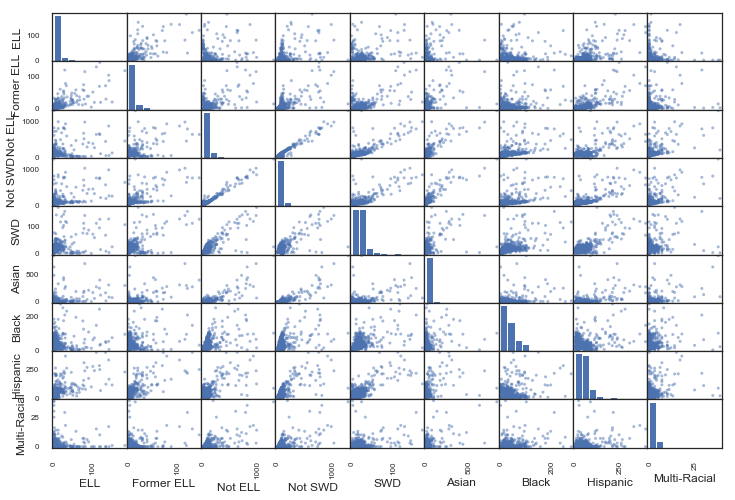

In [66]:
pd.plotting.scatter_matrix(d.iloc[:, 4:13], figsize=(12,8));

In [67]:
# for i in d.columns:
#     d[i] = d[i].map(lambda x: np.log(x))

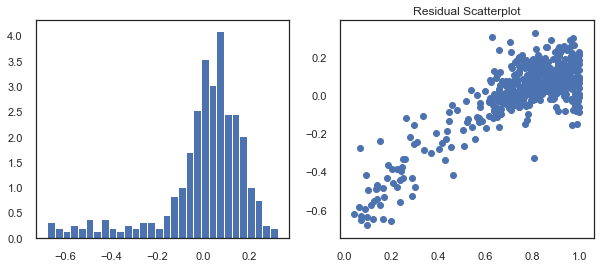

In [68]:
# same as above, except removed the two zeros
checkresiduals(d, 'grad_rate', features_model)

In [70]:
# d['grad_log'] =np['grad_rate'].log(d['grad_rate'])
# checkresiduals(d, 'grad_log', features_model)

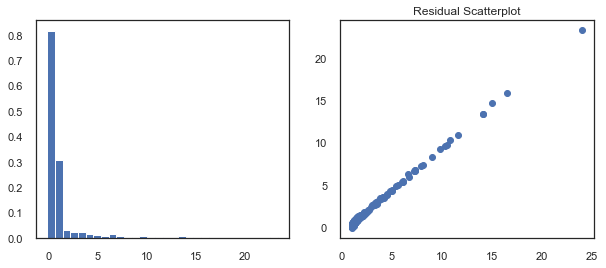

In [71]:
d['grad_recipr'] = 1/d['grad_rate']
checkresiduals(d, 'grad_recipr', features_model)

In [72]:
achievement = pd.read_csv('Data/Student_Achievement.csv', skiprows = 1)
achievement = achievement.rename(columns={'Metric Value - Graduation Rate, 4 year':'gradrate'})

In [73]:
# merge d (which is just the original dataset minus the 2 zero grad_rates)
# with student achievement tab in HS Quality Reports file
newset = d.merge(achievement,on = 'DBN',how = 'inner')

In [74]:
newset = newset.rename(columns={'Student Achievement - Section Score':'SA_score'})

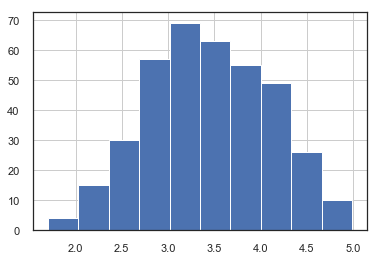

In [75]:
# attempted running model using Student Achievement as target variable instead of grad_rate- too many interactions
newset.SA_score.hist()

In [76]:
newset = newset.drop(['Former ELL', 'Not SWD', 'Asian', 'Hispanic', 'Native American', 'Female'], axis=1)

In [77]:
newset = newset.drop(['prob_ELL', 'prob_SWD', 'prob_Multi-Racial'], axis=1)

In [78]:
merged_set = newset[['DBN',
'School Name_x',
'total_stud',
'grad_rate',
'prob_Former ELL',
'prob_Not ELL',
'prob_Not SWD',
'prob_Asian',
'prob_Black',
'prob_Hispanic',
'prob_Native American',
'prob_White',
'prob_Female',
'prob_Male',
'prob_Econ Disadv',
'prob_Not Econ Disadv',
'SA_score',
'Metric Score - Percentage Earning 10+ Credits in First Year',
'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in First Year',
'Metric Score - Percentage Earning 10+ Credits in Second Year',
'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Second Year',
'Metric Score - Percentage Earning 10+ Credits in Third Year',
'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Third Year',
'Metric Score - Average Completion Rate for Remaining Regents',
'Metric Score - Weighted Regents Pass Rate, English',
'Metric Score - Weighted Regents Pass Rate, Math',
'Metric Score - Weighted Regents Pass Rate, Science'
,'Metric Score - Weighted Regents Pass Rate, Global History'
,'Metric Score - Weighted Regents Pass Rate, US History'
,'Metric Score - Graduation Rate, 4 year'
,'Metric Score - Graduation Rate, 6 year'
,'Metric Score - Weighted Diploma Rate, 4 year'
,'Metric Score - Weighted Diploma Rate, 6 year'
,'Metric Score - College and Career Preparatory Course Index'
,'Metric Score - Four-year College Readiness Index'
,'Metric Score - College Readiness Rate including persistence'
,'Metric Score - Postsecondary Enrollment Rate, 6 months After High School'
,'Metric Score - Postsecondary Enrollment Rate, 18 months After High School'
,'Metric Value - Non-Dropout Rate, 4 year'
,'Metric Value - Non-Dropout Rate, 6 year'
]]

In [79]:
print(d.shape, newset.shape, merged_set.shape)

(473, 36) (420, 136) (420, 40)


In [80]:
merged_set.isna().sum()

DBN                                                                                   0
School Name_x                                                                         0
total_stud                                                                            0
grad_rate                                                                             0
prob_Former ELL                                                                       0
prob_Not ELL                                                                          0
prob_Not SWD                                                                          0
prob_Asian                                                                            0
prob_Black                                                                            0
prob_Hispanic                                                                         0
prob_Native American                                                                  0
prob_White                      

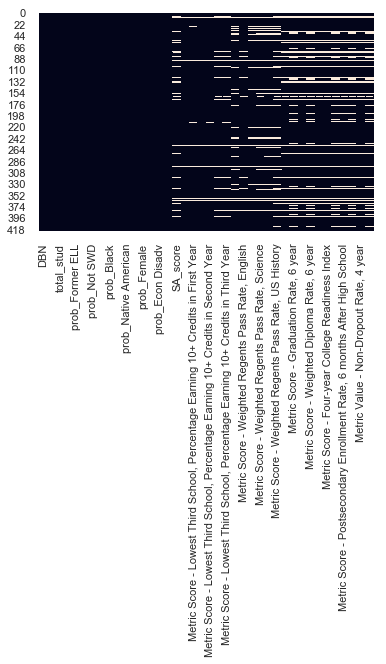

In [81]:
#Checking missing data
sns.heatmap(merged_set.isnull(), cbar=False)

In [82]:
#Replace missing value with 0
merged_set = merged_set.fillna(0)

In [83]:
filtered_cols_m = [
'prob_Former ELL',
'prob_Not ELL',
'prob_Not SWD',
'prob_Asian',
'prob_Black',
'prob_Hispanic',
'prob_White',
'Metric Score - Weighted Regents Pass Rate, Science'
,'Metric Score - Weighted Regents Pass Rate, US History'
,'Metric Score - Four-year College Readiness Index'
]

In [84]:
merged_set[filtered_cols_m].dtypes

prob_Former ELL                                          float64
prob_Not ELL                                             float64
prob_Not SWD                                             float64
prob_Asian                                               float64
prob_Black                                               float64
prob_Hispanic                                            float64
prob_White                                               float64
Metric Score - Weighted Regents Pass Rate, Science       float64
Metric Score - Weighted Regents Pass Rate, US History    float64
Metric Score - Four-year College Readiness Index         float64
dtype: object

In [85]:
features_model = sm.OLS(endog=merged_set['grad_rate'], exog=sm.add_constant(merged_set[filtered_cols_m]) ).fit()

features_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     42.27
Date:                Sun, 01 Sep 2019   Prob (F-statistic):           4.81e-57
Time:                        20:42:19   Log-Likelihood:                 378.78
No. Observations:                 420   AIC:                            -735.6
Df Residuals:                     409   BIC:                            -691.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                    -0.4929      0.232     -2.122      0.034      -0.949      -0.036
prob_Former ELL                                           0.7459      0.106      7.015      0.000       0.537       0.955
prob_Not ELL                                              0.6080      0.049     12.523      0.000       0.513       0.703
prob_Not SWD                                              0.7286      0.073      9.914      0.000       0.584       0.873
prob_Asian                                                0.0891      0.220      0.405      0.686      -0.344       0.522
prob_Black                                                0.0518      0.211      0.245      0.806      -0.363       0.467
prob_Hispanic                                             0.1228      0.210      0.584      0.560      -0.291       0.536
prob_White                                                0.2141      0.212      1.011      0.313      -0.202       0.630
Metric Score - Weighted Regents Pass Rate, Science        0.0033      0.006      0.570      0.569      -0.008       0.015
Metric Score - Weighted Regents Pass Rate, US History     0.0004      0.005      0.074      0.941      -0.010       0.010
Metric Score - Four-year College Readiness Index          0.0076      0.004      2.032      0.043       0.000       0.015
==============================================================================
Omnibus:                       78.425   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.702
Skew:                          -0.929   Prob(JB):                     1.43e-42
Kurtosis:                       5.750   Cond. No.                         561.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

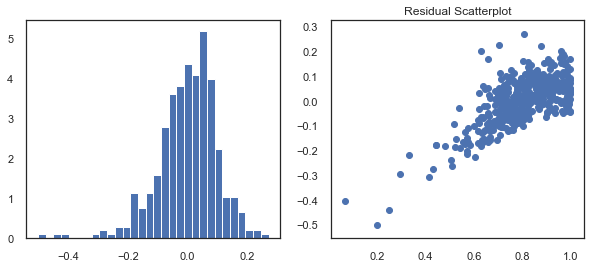

In [86]:
checkresiduals(merged_set, 'grad_rate', features_model)

In [87]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)

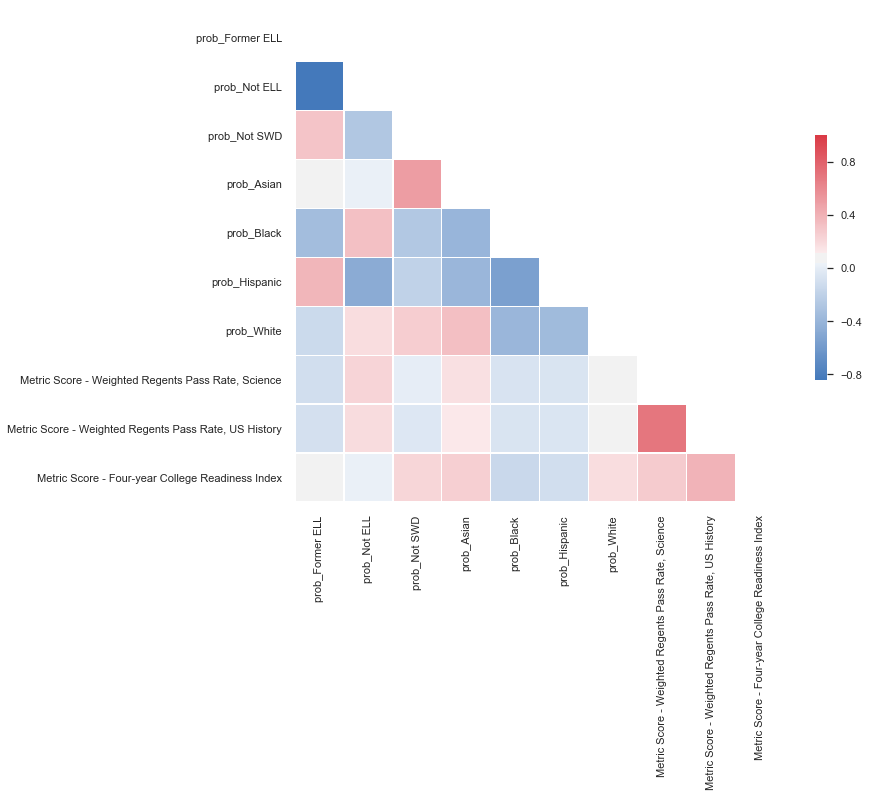

In [88]:
CorrMtx(merged_set[filtered_cols_m].corr(), dropDuplicates = True)

In [89]:
# add Student Quality Review table
sqr = pd.read_csv('Data/SQR_Summary2.csv', skiprows = 1)

In [90]:
# filter columns
sqr = sqr[['DBN', 'Enrollment',
'Rigorous Instruction - Percent Positive',
'Collaborative Teachers - Percent Positive',
'Supportive Environment - Percent Positive',
'Effective School Leadership - Percent Positive',
'Strong Family-Community Ties - Percent Positive',
'Trust - Percent Positive',
'Average Grade 8 English Proficiency',
'Average Grade 8 Math Proficiency', 'Percent English Language Learners',
'Percent Students with Disabilities', 'Percent Self-Contained',
'Economic Need Index', 'Percent in Temp Housing - 4yr',
'Percent HRA Eligible', 'Percent Asian', 'Percent Black',
'Percent Hispanic', 'Percent White',
'Years of principal experience at this school',
'Percent of teachers with 3 or more years of experience',
'Student Attendance Rate', 'Percent of Students Chronically Absent',
'Teacher Attendance Rate']]

In [91]:
len(sqr.columns)

25

In [75]:
# dataset = dataset.rename(columns={'#':'total_stud','% of cohort':'grad_rate'})

In [70]:
# rir_dummies = pd.get_dummies(sqr['Rigorous Instruction Rating'], 'rir', drop_first=True)
# ctr_dummies = pd.get_dummies(sqr['Collaborative Teachers Rating'], 'ctr', drop_first=True)
# ser_dummies = pd.get_dummies(sqr['Supportive Environment Rating'], 'ser', drop_first=True)
# eslr_dummies = pd.get_dummies(sqr['Effective School Leadership Rating'], 'eslr', drop_first=True)
# famr_dummies = pd.get_dummies(sqr['Strong Family-Community Ties Rating'], 'famr', drop_first=True)
# trustr_dummies = pd.get_dummies(sqr['Trust Rating'], 'trustr', drop_first=True)
# sar_dummies = pd.get_dummies(sqr['Student Achievement Rating'], 'sar', drop_first=True)

In [78]:
sqr = pd.concat([sqr, rir_dummies, ctr_dummies, ser_dummies, eslr_dummies, famr_dummies, trustr_dummies, sar_dummies], axis=1)
len(sqr.columns)

61

In [79]:
sqr = sqr.drop(['Rigorous Instruction Rating', 'Collaborative Teachers Rating',
       'Supportive Environment Rating', 'Effective School Leadership Rating',
       'Strong Family-Community Ties Rating', 'Trust Rating',
       'Student Achievement Rating'], axis = 1)

In [80]:
len(sqr.columns)

54

In [90]:
bigset.iloc[:,34:59].dtypes

Metric Score - Four-year College Readiness Index                                          float64
Metric Score - College Readiness Rate including persistence                               float64
Metric Score - Postsecondary Enrollment Rate, 6 months After High School                  float64
Metric Score - Postsecondary Enrollment Rate, 18 months After High School                 float64
Metric Value - Non-Dropout Rate, 4 year                                                    object
Metric Value - Non-Dropout Rate, 6 year                                                    object
School Name                                                                                object
School Type                                                                                object
Rigorous Instruction - Percent Positive                                                   float64
Collaborative Teachers - Percent Positive                                                 float64
Supportive Environme

In [71]:
print(merged_set.shape, sqr.shape)

(420, 40) (491, 25)


In [92]:
# merge merged_set with sqr (third table)
bigset = merged_set.merge(sqr,on = 'DBN',how = 'inner')

In [93]:
bigset.shape

(420, 64)

In [94]:
bigset.isna().sum()

DBN                                                                                  0
School Name_x                                                                        0
total_stud                                                                           0
grad_rate                                                                            0
prob_Former ELL                                                                      0
prob_Not ELL                                                                         0
prob_Not SWD                                                                         0
prob_Asian                                                                           0
prob_Black                                                                           0
prob_Hispanic                                                                        0
prob_Native American                                                                 0
prob_White                                 

In [95]:
#Replace missing value with 0
bigset = bigset.fillna(0)

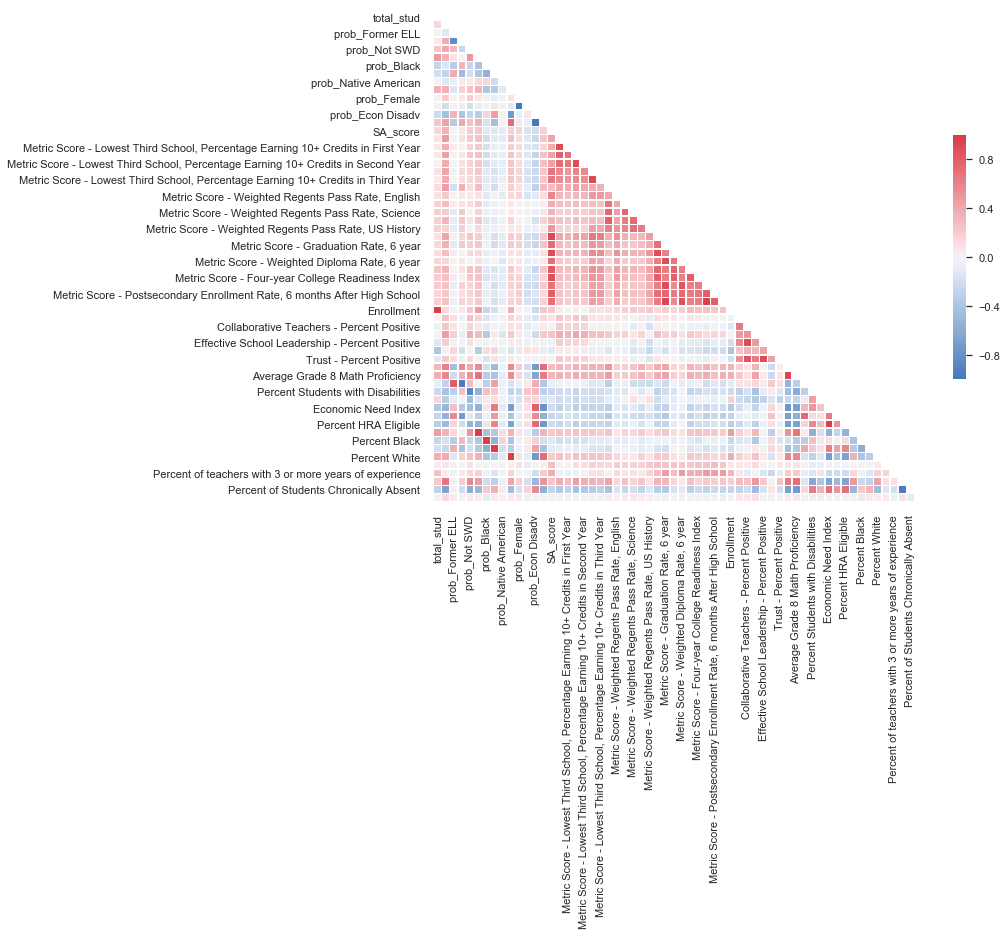

In [96]:
CorrMtx(bigset.corr(), dropDuplicates = True)

In [97]:
bigset = bigset.drop(['Enrollment','Percent Asian', 'Percent Black',
       'Percent Hispanic', 'Percent White',], axis = 1)

In [98]:
for i in bigset['Metric Value - Non-Dropout Rate, 4 year']:
    print(i)

79.2%
89.2%
93.2%
71.3%
99.2%
98.7%
89.7%
0
0
0
0
88.8%
84.4%
89.5%
95.9%
82.6%
74.0%
92.3%
88.4%
94.7%
92.0%
99.0%
87.9%
85.7%
82.1%
89.6%
97.1%
100.0%
100.0%
97.5%
98.9%
100.0%
100.0%
100.0%
68.4%
94.9%
0
77.8%
73.0%
87.2%
69.6%
98.8%
87.1%
91.4%
99.5%
84.9%
81.4%
91.4%
98.8%
72.0%
82.3%
100.0%
0
0
96.7%
82.8%
97.9%
0
92.3%
82.4%
96.1%
90.7%
93.3%
90.9%
84.5%
80.8%
85.0%
85.9%
78.9%
99.0%
100.0%
98.6%
80.7%
77.5%
100.0%
0
85.5%
0
75.0%
97.8%
96.9%
99.0%
100.0%
77.8%
0
81.6%
100.0%
84.0%
84.4%
88.8%
97.6%
97.9%
0
100.0%
81.6%
94.8%
80.9%
73.0%
84.9%
85.4%
93.7%
86.0%
96.2%
0
0
86.8%
72.6%
75.3%
99.1%
92.0%
67.2%
77.4%
78.4%
86.9%
84.3%
78.9%
74.4%
85.1%
80.6%
84.1%
70.9%
79.2%
0
76.9%
0
0
89.5%
84.1%
67.9%
86.0%
68.3%
68.8%
64.2%
0
0
0
70.3%
88.6%
92.7%
92.5%
85.7%
97.3%
78.6%
81.1%
98.3%
0
79.5%
94.4%
91.3%
73.7%
71.0%
97.7%
90.6%
78.4%
78.4%
75.9%
0
88.8%
77.7%
93.6%
85.0%
87.8%
0
82.2%
78.8%
89.4%
0
0
97.0%
83.9%
77.2%
85.1%
97.8%
76.5%
80.7%
66.0%
94.4%
99.9%
97.3%
76.0%
84.3%
78.

In [99]:
bigset.loc[bigset['Metric Value - Non-Dropout Rate, 4 year'] == 0, 'Metric Value - Non-Dropout Rate, 4 year'] = '0%'
# df.loc[df.A==0, 'B'] = df.loc[df.A==0, 'B'] / 2

In [107]:
for i in bigset['Metric Value - Non-Dropout Rate, 4 year']:
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [127]:
bigset['Metric Value - Non-Dropout Rate, 4 year'] = bigset['Metric Value - Non-Dropout Rate, 4 year'].str.replace('[^\d.]', '').astype(float)
# df.code.str.replace('[^\d.]', '').astype(float)

In [128]:
print(bigset['Metric Value - Non-Dropout Rate, 4 year'])

    # df['Price'] = df['Price'].astype(float)
    # bigset['Metric Value - Non-Dropout Rate, 4 year'].astype(float)

0       79.2
1       89.2
2       93.2
3       71.3
4       99.2
5       98.7
6       89.7
7        0.0
8        0.0
9        0.0
10       0.0
11      88.8
12      84.4
13      89.5
14      95.9
15      82.6
16      74.0
17      92.3
18      88.4
19      94.7
20      92.0
21      99.0
22      87.9
23      85.7
24      82.1
25      89.6
26      97.1
27     100.0
28     100.0
29      97.5
       ...  
390      0.0
391     87.9
392     90.2
393      0.0
394    100.0
395     99.0
396     83.9
397     78.4
398     97.7
399     88.8
400     82.8
401     94.9
402    100.0
403     96.7
404     92.9
405     92.5
406     85.0
407     78.9
408     84.4
409     94.0
410     90.9
411     78.7
412     99.3
413     88.2
414     77.5
415     80.8
416     78.4
417     63.5
418     97.5
419      NaN
Name: Metric Value - Non-Dropout Rate, 4 year, Length: 420, dtype: float64


In [133]:
bigset.iloc[:,34:59].dtypes

Metric Score - Four-year College Readiness Index                                          float64
Metric Score - College Readiness Rate including persistence                               float64
Metric Score - Postsecondary Enrollment Rate, 6 months After High School                  float64
Metric Score - Postsecondary Enrollment Rate, 18 months After High School                 float64
Metric Value - Non-Dropout Rate, 4 year                                                   float64
Metric Value - Non-Dropout Rate, 6 year                                                   float64
School Name                                                                                object
School Type                                                                                object
Rigorous Instruction - Percent Positive                                                   float64
Collaborative Teachers - Percent Positive                                                 float64
Supportive Environme

In [131]:
bigset.loc[bigset['Metric Value - Non-Dropout Rate, 6 year'] == 0, 'Metric Value - Non-Dropout Rate, 6 year'] = '0%'

In [132]:
bigset['Metric Value - Non-Dropout Rate, 6 year'] = bigset['Metric Value - Non-Dropout Rate, 6 year'].str.replace('[^\d.]', '').astype(float)
print(bigset['Metric Value - Non-Dropout Rate, 6 year'])

0       74.4
1       82.0
2       85.9
3       58.9
4       97.8
5      100.0
6       93.3
7        0.0
8        0.0
9        0.0
10       0.0
11      93.9
12      76.3
13      76.6
14      93.9
15      78.8
16      70.3
17      88.0
18      85.1
19      84.0
20      83.9
21      96.0
22      87.5
23      76.8
24      79.3
25      91.0
26      98.6
27      97.3
28     100.0
29      98.4
       ...  
390      0.0
391     83.8
392     81.9
393      0.0
394     97.6
395     98.9
396     76.7
397     73.6
398     99.1
399     84.7
400     78.7
401     97.8
402    100.0
403     97.5
404     91.7
405     95.4
406     81.4
407     74.8
408     83.6
409     90.8
410     89.5
411     76.9
412     99.6
413      0.0
414     81.1
415     84.5
416     70.8
417     65.7
418     97.1
419     75.9
Name: Metric Value - Non-Dropout Rate, 6 year, Length: 420, dtype: float64


In [142]:
df.state_bottle_retail.apply(lambda x: x.replace('$','')
# bigset[bigset['Metric Value - Non-Dropout Rate, 4 year']].replace('[\%,]', '', regex=True).astype(float)
# bigset['Metric Value - Non-Dropout Rate, 4 year'].astype(float)
bigset['Metric Value - Non-Dropout Rate, 4 year'] = [x.replace('%','') for x in bigset['Metric Value - Non-Dropout Rate, 4 year'] if '%' in x].astype(np.float)

TypeError: argument of type 'int' is not iterable

In [102]:
filtered_cols_b = [
'total_stud', 'prob_Former ELL',
       'prob_Not ELL', 'prob_Not SWD', 'prob_Asian', 'prob_Black',
       'prob_Hispanic', 'prob_Native American', 'prob_White', 'prob_Female','prob_Econ Disadv', 'SA_score',
       'Metric Score - Percentage Earning 10+ Credits in First Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in First Year',
       'Metric Score - Percentage Earning 10+ Credits in Second Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Second Year',
       'Metric Score - Percentage Earning 10+ Credits in Third Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Third Year',
       'Metric Score - Average Completion Rate for Remaining Regents',
       'Metric Score - Weighted Regents Pass Rate, English',
       'Metric Score - Weighted Regents Pass Rate, Math',
       'Metric Score - Weighted Regents Pass Rate, Science',
       'Metric Score - Weighted Regents Pass Rate, Global History',
       'Metric Score - Weighted Regents Pass Rate, US History',
       'Metric Score - Graduation Rate, 4 year',
       'Metric Score - Graduation Rate, 6 year',
       'Metric Score - Weighted Diploma Rate, 4 year',
       'Metric Score - Weighted Diploma Rate, 6 year',
       'Metric Score - College and Career Preparatory Course Index',
       'Metric Score - Four-year College Readiness Index',
       'Metric Score - College Readiness Rate including persistence',
       'Metric Score - Postsecondary Enrollment Rate, 6 months After High School',
       'Metric Score - Postsecondary Enrollment Rate, 18 months After High School',
       'Rigorous Instruction - Percent Positive',
       'Collaborative Teachers - Percent Positive','Supportive Environment - Percent Positive',
       'Effective School Leadership - Percent Positive', 'Strong Family-Community Ties - Percent Positive',
       'Trust - Percent Positive', 'Average Grade 8 English Proficiency',
       'Average Grade 8 Math Proficiency', 'Percent English Language Learners',
       'Percent Students with Disabilities', 'Percent Self-Contained',
       'Economic Need Index', 'Percent in Temp Housing - 4yr',
       'Percent HRA Eligible', 'Years of principal experience at this school',
       'Percent of teachers with 3 or more years of experience',
       'Student Attendance Rate', 'Percent of Students Chronically Absent', 'Teacher Attendance Rate'
]

In [103]:
bigset[filtered_cols_b].dtypes

total_stud                                                                             int64
prob_Former ELL                                                                      float64
prob_Not ELL                                                                         float64
prob_Not SWD                                                                         float64
prob_Asian                                                                           float64
prob_Black                                                                           float64
prob_Hispanic                                                                        float64
prob_Native American                                                                 float64
prob_White                                                                           float64
prob_Female                                                                          float64
prob_Econ Disadv                                                      

In [104]:
features_model = sm.OLS(endog=bigset['grad_rate'], exog=sm.add_constant(bigset[filtered_cols_b]) ).fit()

features_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     17.29
Date:                Sun, 01 Sep 2019   Prob (F-statistic):           5.88e-71
Time:                        20:44:15   Log-Likelihood:                 489.75
No. Observations:                 420   AIC:                            -873.5
Df Residuals:                     367   BIC:                            -659.4
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                -1.4054      0.441     -3.190      0.002      -2.272      -0.539
total_stud                                                                        -1.546e-05    2.9e-05     -0.533      0.595   -7.26e-05    4.16e-05
prob_Former ELL                                                                       0.5546      0.099      5.625      0.000       0.361       0.748
prob_Not ELL                                                                          0.6604      0.094      7.013      0.000       0.475       0.846
prob_Not SWD                                                                          0.2504      0.105      2.382      0.018       0.044       0.457
prob_Asian                                                                           -0.1620      0.220     -0.736      0.462      -0.595       0.271
prob_Black                                                                           -0.1626      0.212     -0.767      0.444      -0.580       0.255
prob_Hispanic                                                                        -0.1514      0.213     -0.709      0.479      -0.571       0.268
prob_Native American                                                                 -1.2981      0.409     -3.174      0.002      -2.102      -0.494
prob_White                                                                           -0.1794      0.212     -0.846      0.398      -0.596       0.237
prob_Female                                                                           0.0081      0.032      0.254      0.800      -0.055       0.071
prob_Econ Disadv                                                                      0.0550      0.059      0.936      0.350      -0.061       0.171
SA_score                                                                              0.0134      0.018      0.754      0.451      -0.022       0.048
Metric Score - Percentage Earning 10+ Credits in First Year                           0.0217      0.010      2.101      0.036       0.001       0.042
Metric Score - Lowest Third School, Percentage Earning 10+ Credits in First Year     -0.0051      0.008     -0.607      0.544      -0.022       0.011
Metric Score - Percentage Earning 10+ Credits in Second Year                         -0.0088      0.010     -0.907      0.365      -0.028       0.010
Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Second Year    -0.0047      0.008     -0.595      0.552      -0.020       0.011
Metric Score - Percentage Earning 10+ Credits in Third Year                        

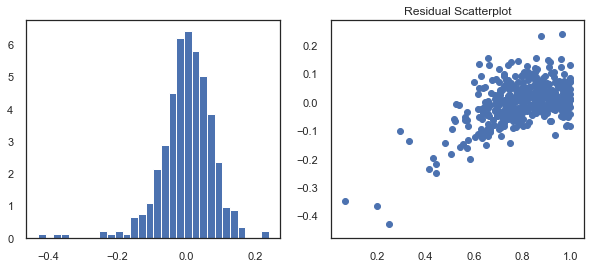

In [105]:
checkresiduals(bigset, 'grad_rate', features_model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=20,test_size=0.2)
scaler = preprocessing.StandardScaler()

## scaling every feature except the binary column female
scaler.fit(X_train.iloc[:,:-1])
transformed_training_features = scaler.transform(X_train.iloc[:,:-1])
transformed_testing_features = scaler.transform(X_test.iloc[:,:-1])

X_train_transformed = pd.DataFrame(scaler.transform(X_train.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_train.index)
X_train_transformed['female'] = X_train['female']

X_test_transformed = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_test.index)
X_test_transformed['female'] = X_test['female']

In [ ]:
def run_model(model,X_train,X_test,y_train,y_test):
    
    print('Training R^2 :',model.score(X_train,y_train))
    y_pred_train = model.predict(X_train)
    print('Training Root Mean Square Error',np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
    print('\n----------------\n')
    print('Testing R^2 :',model.score(X_test,y_test))
    y_pred_test = model.predict(X_test)
    print('Testing Root Mean Square Error',np.sqrt(metrics.mean_squared_error(y_test,y_pred_test)))

In [ ]:
lm = LinearRegression()
lm.fit(X_train_transformed,y_train)
run_model(lm,X_train_transformed,X_test_transformed,y_train,y_test)

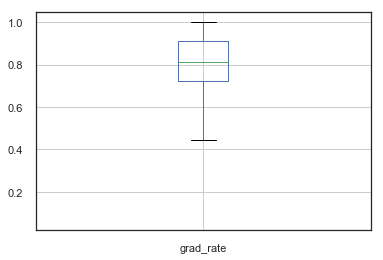

In [66]:
bigset.boxplot(['grad_rate'])

In [100]:
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(bigset[filtered_cols_b])
poly_columns = poly.get_feature_names(bigset[filtered_cols_b].columns)
poly_features = pd.DataFrame(poly_data, columns=poly_columns, index=bigset.index)
# scaler.fit(poly_features)
# scaled_features = scaler.transform(poly_features)

poly_scaled_features = pd.DataFrame(poly_features, columns=poly_columns, index=bigset.index)

In [101]:
poly_scaled_features = poly_scaled_features.drop(['1'], axis=1)

In [102]:
poly_scaled_features_model = sm.OLS(endog=merged_set['grad_rate'], exog=sm.add_constant(poly_scaled_features)).fit()

poly_scaled_features_model.summary()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encou

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Wed, 28 Aug 2019   Prob (F-statistic):                nan
Time:                        13:55:34   Log-Likelihood:                 9622.7
No. Observations:                 420   AIC:                        -1.841e+04
Df Residuals:                       0   BIC:                        -1.671e+04
Df Model:                         419                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================================================================================
                                                                                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                                 -0.0012        inf         -0        nan         nan         nan
total_stud                                                                                                                                                             0.0228        inf          0        nan         nan         nan
prob_Former ELL                                                                                                                                                       -0.0016        inf         -0        nan         nan         nan
prob_Not ELL                                                                                                                                                           0.0027        inf          0        nan         nan         nan
prob_Not SWD                                                                                                                                                           0.0028        inf          0        nan         nan         nan
prob_Asian                                                                                                                                                            -0.0062        inf         -0        nan         nan         nan
prob_Black                                                                                                                                                             0.0047        inf          0        nan         nan         nan
prob_Hispanic                                                                                                                                                         -0.0032        inf         -0        nan         nan         nan
prob_Native American                                                                                                                                                  -0.0008        inf         -0        nan         nan         nan
prob_White                                                                                                                                                             0.0039        inf          0        nan         nan         nan
prob_Female                                                                     

In [150]:
trimmedset = bigset[bigset['grad_rate'] >= .5]

In [151]:
trimmedset.columns

Index(['DBN', 'School Name_x', 'total_stud', 'grad_rate', 'prob_Former ELL',
       'prob_Not ELL', 'prob_Not SWD', 'prob_Asian', 'prob_Black',
       'prob_Hispanic', 'prob_Native American', 'prob_White', 'prob_Female',
       'prob_Male', 'prob_Econ Disadv', 'prob_Not Econ Disadv', 'SA_score',
       'Metric Score - Percentage Earning 10+ Credits in First Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in First Year',
       'Metric Score - Percentage Earning 10+ Credits in Second Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Second Year',
       'Metric Score - Percentage Earning 10+ Credits in Third Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Third Year',
       'Metric Score - Average Completion Rate for Remaining Regents',
       'Metric Score - Weighted Regents Pass Rate, English',
       'Metric Score - Weighted Regents Pass Rate, Math',
       'Metric Score - Weigh

In [181]:
# 'prob_Not SWD', 'Trust - Percent Positive', 'Collaborative Teachers - Percent Positive',
filtered_cols_tt = [
'prob_Former ELL',
       'prob_Not ELL', 'SA_score',
       'Metric Score - Percentage Earning 10+ Credits in First Year',
       'Supportive Environment - Percent Positive',
       'Average Grade 8 English Proficiency', 'Percent English Language Learners',
'Percent in Temp Housing - 4yr',
       'Student Attendance Rate',
       'Teacher Attendance Rate'
]

In [182]:
features_model = sm.OLS(endog=trimmedset['grad_rate'], exog=sm.add_constant(trimmedset[filtered_cols_tt]) ).fit()

features_model.summary()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     91.10
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           1.63e-96
Time:                        11:15:31   Log-Likelihood:                 534.07
No. Observations:                 410   AIC:                            -1046.
Df Residuals:                     399   BIC:                            -1002.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                          -0.8649      0.108     -7.978      0.000      -1.078      -0.652
prob_Former ELL                                                 0.2975      0.077      3.871      0.000       0.146       0.449
prob_Not ELL                                                    0.5254      0.078      6.778      0.000       0.373       0.678
SA_score                                                        0.0086      0.003      2.728      0.007       0.002       0.015
Metric Score - Percentage Earning 10+ Credits in First Year     0.0180      0.003      5.258      0.000       0.011       0.025
Supportive Environment - Percent Positive                       0.2235      0.078      2.860      0.004       0.070       0.377
Average Grade 8 English Proficiency                             0.0469      0.015      3.174      0.002       0.018       0.076
Percent English Language Learners                               0.4109      0.080      5.105      0.000       0.253       0.569
Percent in Temp Housing - 4yr                                  -0.3683      0.097     -3.810      0.000      -0.558      -0.178
Student Attendance Rate                                         0.6355      0.100      6.339      0.000       0.438       0.833
Teacher Attendance Rate                                         0.2678      0.068      3.931      0.000       0.134       0.402
==============================================================================
Omnibus:                        7.113   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                8.080
Skew:                          -0.208   Prob(JB):                       0.0176
Kurtosis:                       3.548   Cond. No.                         235.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

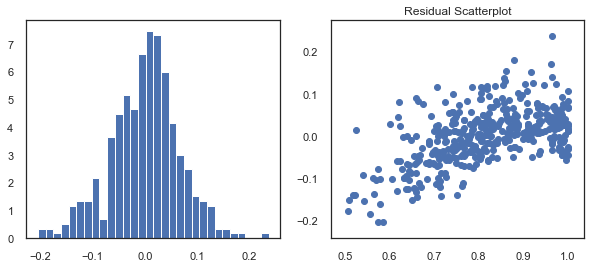

In [183]:
checkresiduals(trimmedset,'grad_rate', features_model)

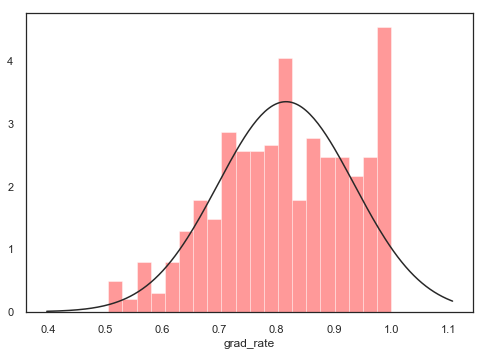

In [155]:
sns.distplot(trimmedset['grad_rate'], fit=norm, bins=20, kde=False, color = 'red')

In [186]:
len(poly_scaled_features.columns)

65

In [187]:
poly_scaled_features_model = sm.OLS(endog=trimmedset['grad_rate'], exog=sm.add_constant(poly_scaled_features)).fit()

poly_scaled_features_model.summary()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     18.26
Date:                Fri, 23 Aug 2019   Prob (F-statistic):           9.89e-79
Time:                        11:16:14   Log-Likelihood:                 596.41
No. Observations:                 410   AIC:                            -1061.
Df Residuals:                     344   BIC:                            -795.8
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================================
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                    -6.2442      9.465     -0.660      0.510     -24.860      12.372
prob_Former ELL                                                                                          13.0831     10.467      1.250      0.212      -7.504      33.670
prob_Not ELL                                                                                              8.0704      9.162      0.881      0.379      -9.951      26.091
SA_score                                                                                                 -0.2470      0.347     -0.711      0.477      -0.930       0.436
Metric Score - Percentage Earning 10+ Credits in First Year                                               0.3499      0.316      1.107      0.269      -0.272       0.971
Supportive Environment - Percent Positive                                                                -3.3634      7.729     -0.435      0.664     -18.565      11.839
Average Grade 8 English Proficiency                                                                       1.0030      1.649      0.608      0.543      -2.241       4.247
Percent English Language Learners                                                                         8.0147      9.282      0.863      0.388     -10.242      26.271
Percent in Temp Housing - 4yr                                                                            -2.2224     10.246     -0.217      0.828     -22.375      17.930
Student Attendance Rate                                                                                  -6.1986      8.733     -0.710      0.478     -23.374      10.977
Teacher Attendance Rate                                                                                   9.6926      9.892      0.980      0.328      -9.763      29.148
prob_Former ELL^2                                                                                         0.2259      0.954      0.237      0.813      -1.650       2.102
prob_Former ELL prob_Not ELL                                                                              2.6050      1.584      1.645      0.101      -0.510       5.720
prob_Former ELL SA_score                                                                                  0.0757      0.120      0.630      0.529      -0.161       0.312
prob_Former ELL Metric Score - Percentage Earning 10+ Credits in First Year                               0.0801      0.107      0.749      0.454      -0.130       0.290
prob_Former ELL Support

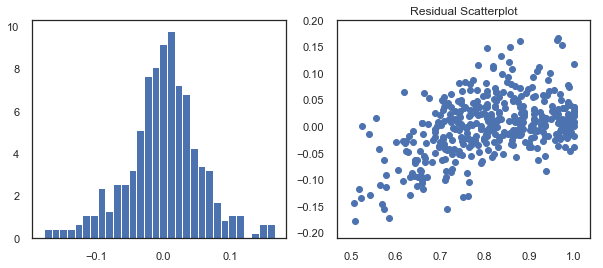

In [170]:
checkresiduals(trimmedset,'grad_rate', poly_scaled_features_model)

In [173]:
trimmedset[filtered_cols_t].describe()

,prob_Former ELL,prob_Not ELL,SA_score,Metric Score - Percentage Earning 10+ Credits in First Year,Supportive Environment - Percent Positive,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Percent English Language Learners,Percent in Temp Housing - 4yr,Student Attendance Rate,Teacher Attendance Rate
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,0.070878,0.840707,3.115951,3.363756,0.830659,2.445293,2.360439,0.123888,0.097446,0.877122,0.964683
std,0.087657,0.204491,1.211328,1.160724,0.052468,0.399995,0.398953,0.189194,0.063282,0.054410,0.048895
min,0.000000,0.010000,0.000000,0.000000,0.660000,1.730000,1.860000,0.000000,0.003000,0.720000,0.000000
25%,0.020000,0.810000,2.772500,2.670000,0.790000,2.220000,2.100000,0.026000,0.056000,0.840000,0.960000
50%,0.050000,0.900000,3.340000,3.550000,0.830000,2.340000,2.230000,0.064000,0.085000,0.880000,0.970000
75%,0.090000,0.960000,3.870000,4.287500,0.870000,2.560000,2.467500,0.127750,0.128000,0.920000,0.970000
max,0.600000,1.000000,4.990000,4.990000,1.000000,4.010000,4.170000,0.923000,0.416000,0.980000,0.990000


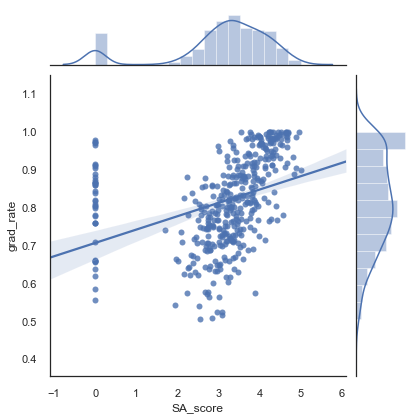

In [431]:
sns.jointplot(x='SA_score', y='grad_rate', data=biggerset, kind="reg")

In [432]:
betterset = trimmedset[trimmedset['SA_score'] > 0]

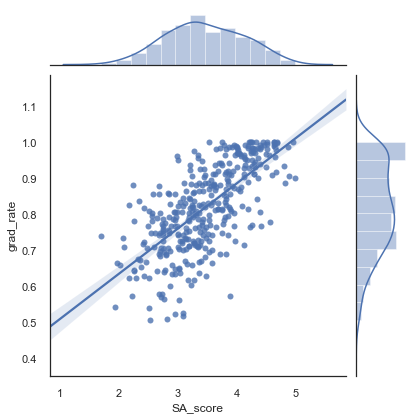

In [433]:
sns.jointplot(x='SA_score', y='grad_rate', data=trimmedset, kind="reg")

In [179]:
trimmedset.columns

Index(['DBN', 'School Name_x', 'total_stud', 'grad_rate', 'prob_Former ELL',
       'prob_Not ELL', 'prob_Not SWD', 'prob_Asian', 'prob_Black',
       'prob_Hispanic', 'prob_Native American', 'prob_White', 'prob_Female',
       'prob_Male', 'prob_Econ Disadv', 'prob_Not Econ Disadv', 'SA_score',
       'Metric Score - Percentage Earning 10+ Credits in First Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in First Year',
       'Metric Score - Percentage Earning 10+ Credits in Second Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Second Year',
       'Metric Score - Percentage Earning 10+ Credits in Third Year',
       'Metric Score - Lowest Third School, Percentage Earning 10+ Credits in Third Year',
       'Metric Score - Average Completion Rate for Remaining Regents',
       'Metric Score - Weighted Regents Pass Rate, English',
       'Metric Score - Weighted Regents Pass Rate, Math',
       'Metric Score - Weigh

In [ ]:
Student Attendance Rate

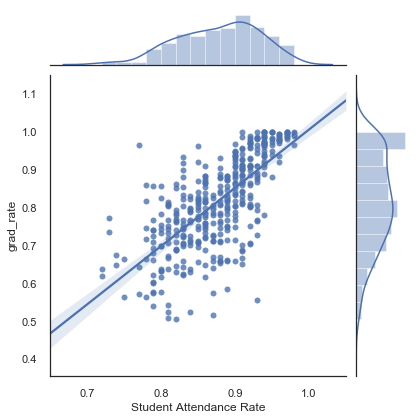

In [180]:
sns.jointplot(x='Student Attendance Rate', y='grad_rate', data=trimmedset, kind="reg")

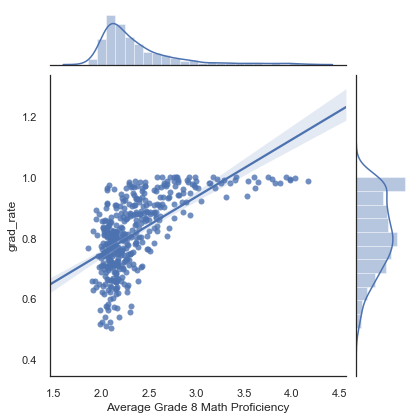

In [436]:
sns.jointplot(x='Average Grade 8 Math Proficiency', y='grad_rate', data=biggerset, kind="reg")

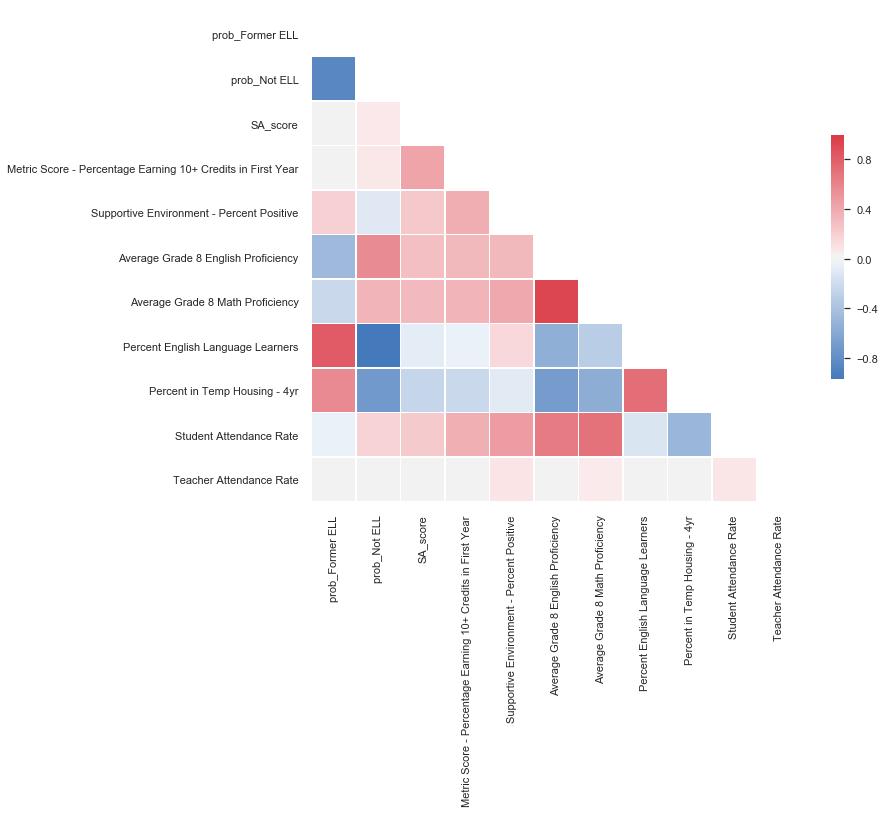

In [445]:
CorrMtx(biggerset[filtered_cols].corr(), dropDuplicates = True)

In [ ]:
scaler = StandardScaler()
scaler.fit(merged_set[filtered_cols])
scaled_features = scaler.transform(merged_set[filtered_cols])

scaled_features_dataset = pd.DataFrame(scaled_features, columns=filtered_cols, index=dataset.index)
scaled_features_dataset.head()

In [ ]:
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(merged_set[filtered_cols])
poly_columns = poly.get_feature_names(merged_set[filtered_cols].columns)
poly_features = pd.DataFrame(poly_data, columns=poly_columns, index=dataset.index)
scaler.fit(poly_features)
scaled_features = scaler.transform(poly_features)

poly_scaled_features = pd.DataFrame(scaled_features, columns=poly_columns, index=dataset.index)
poly_scaled_features.head(15)

poly_scaled_features['1'].describe()
# poly_scaled_features = poly_scaled_features.drop(['1'], axis=1)

In [298]:
# poly_scaled_features_model = sm.OLS(endog=df['price_log'], exog=sm.add_constant(poly_scaled_features)).fit()

poly_scaled_features_model = sm.OLS(endog=merged_set['grad_rate'], exog=sm.add_constant(poly_scaled_features)).fit()

poly_scaled_features_model.summary()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     11.31
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           3.96e-55
Time:                        15:56:09   Log-Likelihood:                 465.76
No. Observations:                 420   AIC:                            -799.5
Df Residuals:                     354   BIC:                            -532.9
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================
                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                        0.8049      0.004    189.705      0.000       0.797       0.813
1                                                                                                          1.44e-14   3.68e-14      0.391      0.696    -5.8e-14    8.68e-14
prob_Former ELL                                                                                              1.3971      0.600      2.327      0.021       0.217       2.578
prob_Not ELL                                                                                                 0.1019      0.671      0.152      0.879      -1.217       1.421
prob_Not SWD                                                                                                 0.0057      0.321      0.018      0.986      -0.625       0.636
prob_Asian                                                                                                   0.3202      1.694      0.189      0.850      -3.012       3.652
prob_Black                                                                                                   0.5116      2.675      0.191      0.848      -4.750       5.773
prob_Hispanic                                                                                                0.3165      2.744      0.115      0.908      -5.079       5.712
prob_White                                                                                                   0.5620      1.424      0.395      0.693      -2.238       3.362
Metric Score - Weighted Regents Pass Rate, Science                                                           0.2304      0.369      0.625      0.533      -0.495       0.956
Metric Score - Weighted Regents Pass Rate, US History                                                       -0.3223      0.427     -0.754      0.451      -1.163       0.518
Metric Score - Four-year College Readiness Index                                                             0.2579      0.301      0.858      0.391      -0.333       0.849
prob_Former ELL^2                                                                                           -0.0358      0.041     -0.867      0.387      -0.117       0.045
prob_Former ELL prob_Not ELL                                                                                -0.0307      0.036     -0.847      0.397      -0.102       0.041
prob_Former ELL prob_Not SWD                                                                                -0.3498      0.156     -2.241     